# Making noise with EEG
MD

Plays frequencies according to either one EEG channel or the sum of all EEG channels at a certain time.

By default the raw EEG music is commented out - running this notebook will play the mean EEG signal per second!

In [543]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyaudio

In [544]:
# df = pd.read_csv('blinks.csv')
df = pd.read_csv('motion.csv') 
df['Index'] = df.index

In [545]:
df["EXG Sum"] = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', 
                    ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', 
                    ' EXG Channel 6', ' EXG Channel 7']].sum(axis=1)
print(df.columns)
print(df['EXG Sum'])
df = df.iloc[5:]

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' Accel Channel 0', ' Accel Channel 1',
       ' Accel Channel 2', ' Other', ' Other.1', ' Other.2', ' Other.3',
       ' Other.4', ' Other.5', ' Other.6', ' Analog Channel 0',
       ' Analog Channel 1', ' Analog Channel 2', ' Timestamp', ' Other.7',
       ' Timestamp (Formatted)', 'Index', 'EXG Sum'],
      dtype='object')
0       -214316.505410
1       -214905.496228
2       -214777.264270
3             0.000000
4       -319159.441490
             ...      
48320    137962.633427
48321    138630.503551
48322    139332.705955
48323    138802.030838
48324    138050.967521
Name: EXG Sum, Length: 48325, dtype: float64


# Basic data visualization for one channel
Change the following cell to select a channel

In [546]:
# selected_channel = ' EXG Channel 0'
selected_channel = 'EXG Sum'

In [547]:
exg_min = df[selected_channel].min()
exg_max = df[selected_channel].max()
exg_range = exg_max - exg_min

print(f"Range: {exg_range} (Min: {exg_min}, Max: {exg_max})")


Range: 578088.195990109 (Min: -403466.98057257896, Max: 174621.21541753)


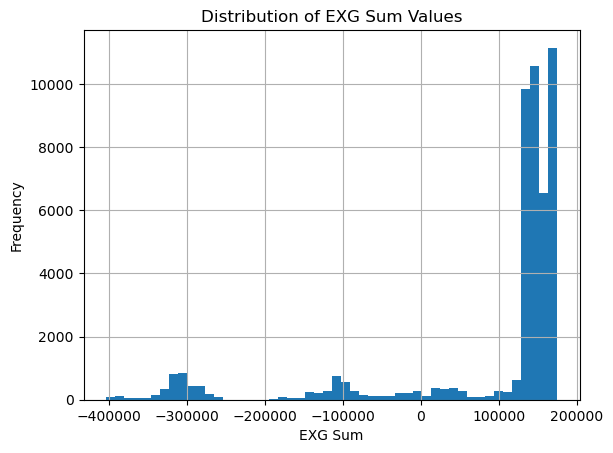

In [548]:
df[selected_channel].hist(bins=50)  # Adjust bins as needed
plt.xlabel(selected_channel)
plt.ylabel("Frequency")
plt.title(f"Distribution of {selected_channel} Values")
plt.show()


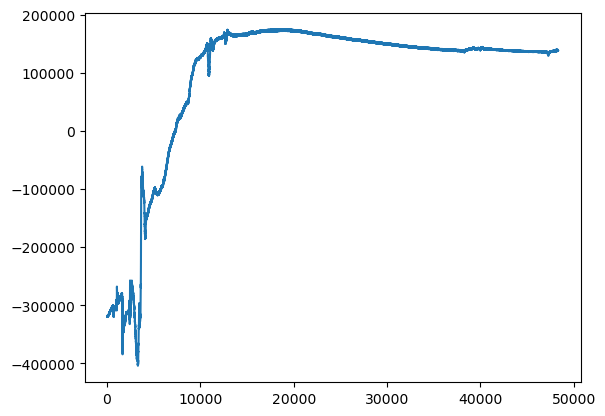

In [549]:
# view raw data
start = 5 # ignore noise at the beginning

x = np.array(df['Index'][start:])
y = np.array(df[selected_channel][start:])

plt.plot(x,y)
plt.show()

# Function to play music based on sum of EEG signals
Displays the normalized frequency list and a graph adjusted for frequency so you can follow the tones.

The duration parameter is the length in seconds a tone is played.

You can change the frequencies here https://education.ti.com/en/~/media/397f23785ac34965bc1629b427f18405.ashx?h=16&thn=1&w=16&rev=8b781082-dee9-4a0f-9d9e-4b6ade7db41b

In [550]:
def play(df=df, duration=0.05):
    df["EXG Sum"] = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', 
                    ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', 
                    ' EXG Channel 6', ' EXG Channel 7']].sum(axis=1)
    print(df.columns)
    print(df['EXG Sum'])
    df = df.iloc[5:]
    
    # Normalize sum to frequency range (min Hz to max Hz)
    min = 110
    max = 440
    min_exg, max_exg = df[selected_channel].min(), df[selected_channel].max()
    df["Frequency"] = 200 + (df[selected_channel] - min_exg) / (max_exg - min_exg) * (max - min)
    print(df['Frequency'])
    df['Index'] = df.index

    start = 5 # ignore noise at the beginning

    x = np.array(df['Index'][start:])
    y = np.array(df['Frequency'][start:])

    plt.plot(x,y)
    plt.show()

    # Audio settings
    RATE = 44100  # Sample rate
    DURATION = duration  # Duration per sound in seconds
    CHUNK = 1024  # Audio chunk size

    # Initialize PyAudio
    p = pyaudio.PyAudio()

    # Function to generate a sine wave
    def generate_sine_wave(frequency, duration, rate):
        t = np.linspace(0, duration, int(rate * duration), endpoint=False)
        wave = (np.sin(2 * np.pi * frequency * t) * 0.5).astype(np.float32)  # Normalize amplitude
        return wave.tobytes()

    # Stream audio for each row in the dataframe
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, output=True)

    for freq in df["Frequency"]:
        wave_data = generate_sine_wave(freq, DURATION, RATE)
        stream.write(wave_data)

    # Stop stream
    stream.stop_stream()
    stream.close()
    p.terminate()


In [551]:
# play(df, duration=0.03) # plays raw EEG data

# Adjust for the mean of each second
Calculate the mean frequency per channel at every second, then play EEG sum as normal

In [552]:
# Convert Timestamp (Formatted) to datetime for easier processing
df[' Timestamp (Formatted)'] = pd.to_datetime(df[' Timestamp (Formatted)'])

# Extract the second part of the timestamp
df['Timestamp_Second'] = df[' Timestamp (Formatted)'].dt.floor('S')

# Group by the Timestamp (ignoring the milliseconds) and calculate the mean of each column
df_grouped = df.groupby('Timestamp_Second').mean().reset_index()

# Show the result
print(df_grouped)

       Timestamp_Second  Sample Index   EXG Channel 0   EXG Channel 1  \
0   2025-02-13 21:08:06     67.500000    46771.965062    44144.417257   
1   2025-02-13 21:08:07    127.428000    46847.983491    44113.039507   
2   2025-02-13 21:08:08    127.572000    47032.125566    44142.847346   
3   2025-02-13 21:08:09    127.669323    46406.905738    43542.195390   
4   2025-02-13 21:08:10    127.836000    45985.780148    43094.913434   
..                  ...           ...             ...             ...   
189 2025-02-13 21:11:15    128.916000    44088.356476    39335.038344   
190 2025-02-13 21:11:16    129.060000    44365.089043    39447.899276   
191 2025-02-13 21:11:17    128.904382    44340.514124    39420.997845   
192 2025-02-13 21:11:18    129.324000    44435.911082    39427.200577   
193 2025-02-13 21:11:19    121.000000    44508.766987    39354.809877   

      EXG Channel 2   EXG Channel 3   EXG Channel 4   EXG Channel 5  \
0      -2593.663068   -11458.944710    55013.361256 

/var/folders/kl/mf67c0m52sn81pgn606s8rh40000gn/T/ipykernel_17541/358162.py:5: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['Timestamp_Second'] = df[' Timestamp (Formatted)'].dt.floor('S')


In [553]:
# df_grouped["EXG Sum"] = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', 
#                     ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', 
#                     ' EXG Channel 6', ' EXG Channel 7']].sum(axis=1)
# print(df_grouped.columns)
# # print(df_grouped['EXG Sum'])

Index(['Timestamp_Second', 'Sample Index', ' EXG Channel 0', ' EXG Channel 1',
       ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5',
       ' EXG Channel 6', ' EXG Channel 7', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Other', ' Other.1',
       ' Other.2', ' Other.3', ' Other.4', ' Other.5', ' Other.6',
       ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2',
       ' Timestamp', ' Other.7', ' Timestamp (Formatted)', 'Index', 'EXG Sum'],
      dtype='object')
0     -318450.206245
1     -313150.308657
2     -304544.772690
3     -307026.098271
4     -293720.284905
           ...      
189    134361.138506
190    136434.428028
191    137197.645329
192    137778.654162
193    138529.663887
Name: EXG Sum, Length: 194, dtype: float64
5      256.113436
6      260.913879
7      230.896795
8      239.833559
9      245.047092
          ...    
189    507.080839
190    508.300912
191    508.750044
192    509.091951
193    509.533900

/var/folders/kl/mf67c0m52sn81pgn606s8rh40000gn/T/ipykernel_17541/761755521.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Frequency"] = 200 + (df[selected_channel] - min_exg) / (max_exg - min_exg) * (max - min)
/var/folders/kl/mf67c0m52sn81pgn606s8rh40000gn/T/ipykernel_17541/761755521.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Index'] = df.index


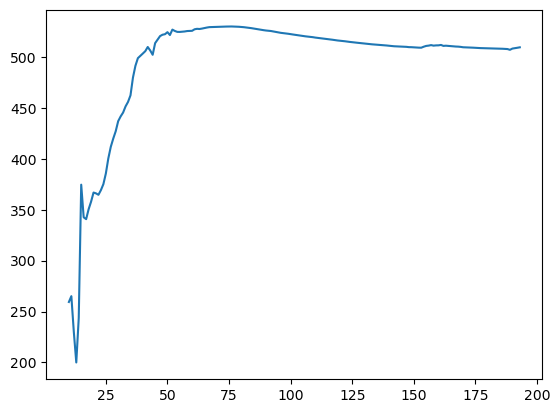

||PaMacCore (AUHAL)|| Warning on line 520: err=''!dev'', msg=Audio Hardware: Bad Device
||PaMacCore (AUHAL)|| Warning on line 440: err=''!dev'', msg=Audio Hardware: Bad Device
||PaMacCore (AUHAL)|| Error on line 1316: err='-10851', msg=Audio Unit: Invalid Property Value


OSError: [Errno -9986] Internal PortAudio error

In [555]:
play(df_grouped, duration=0.05)